In [1]:
from IPython.display import Image 

As a Data Scientist, we have now trained a model on the sample data of the CryptoPunks dataset in a notebook, converted the notebook to a python file and published the code on the Ocean marketplace. In this notebook, we will use this code to initiate compute-to-data (C2D). 

In [2]:
import time

import _init_paths
from ocean_lib.ocean.ocean import Ocean
from ocean_lib.config import Config

config = Config('config.ini')
ocean = Ocean(config)

print(f"config.network_url = '{config.network_url}'")
print(f"config.block_confirmations = {config.block_confirmations.value}")
print(f"config.metadata_cache_uri = '{config.metadata_cache_uri}'")
print(f"config.provider_url = '{config.provider_url}'")

config.network_url = 'https://rinkeby.infura.io/v3/d163c48816434b0bbb3ac3925d6c6c80'
config.block_confirmations = 0
config.metadata_cache_uri = 'https://aquarius.oceanprotocol.com'
config.provider_url = 'https://provider.rinkeby.oceanprotocol.com'


In [3]:
import os
from ocean_lib.web3_internal.wallet import Wallet

wallet = Wallet(ocean.web3, os.getenv('MY_TEST_KEY'), transaction_timeout=20, block_confirmations=config.block_confirmations)

print(f"public address = '{wallet.address}'")

public address = '0x2338e4e94AEe1817701F65f2c751f7c844b0e43b'


As before, we will use the CryptoPunks dataset. We can find the CryptoPunks dataset using the DDO listed in the ocean marketplace web app. Alternatively, we could search for it by name using the Python API. 

In [4]:
DATA_ddo = ocean.assets.resolve("2")
data_token = ocean.get_data_token(DATA_ddo.data_token_address)
token_address = data_token.address

print(f"Data token info = '{DATA_ddo.values['dataTokenInfo']}'")
print(f"Dataset name = '{DATA_ddo.metadata['main']['name']}'")
print(f"Data token address = '{data_token.address}'")

Data token info = '{'address': '0xd21196A9AC0A0Aa9df1ef6f30a440584Fe1C5E7b', 'name': 'Tremendous Barnacle Token', 'symbol': 'TREBAR-64', 'decimals': 18, 'cap': 1000.0}'
Dataset name = 'CryptoPunks Images Download Dropbox'
Data token address = '0xd21196A9AC0A0Aa9df1ef6f30a440584Fe1C5E7b'


## Acquire datatokens for data and algorithm

For compute-to-data, we need at least one data token and one algorithm token. Let's check if we have any of the required data tokens in our wallet.

In [5]:
token_address = data_token.address

In [6]:
from ocean_lib.web3_internal.currency import pretty_ether_and_wei
print(f"Data Scientist has {pretty_ether_and_wei(data_token.balanceOf(wallet.address), data_token.symbol())} data tokens.")

Data Scientist has 5.98 TREBAR-64 (5989000000000000000 wei) data tokens.


You won't have any the first time you run this code (or after you run a compute job). We can either purchase some data tokens from the liquidity pool using the Ocean marketplace app or using the Python API. I used the GUI to find the pool address (as shown in the image below). There should be an ocean.py function to do this but couldn't find it. 

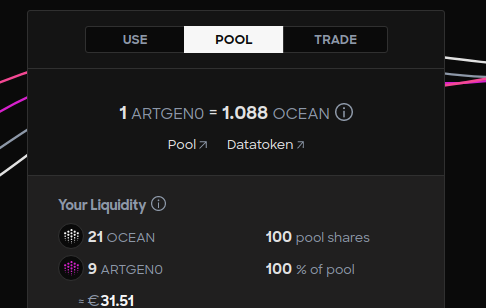

In [28]:
display(Image(filename='images/pool-address.png', width = 400))

In [11]:
data_pool_address = "0x2d35D25C5BF1005B310284d00Ad05b9F35ea827B"
print(f"Pool has {pretty_ether_and_wei(data_token.balanceOf(data_pool_address), data_token.symbol())}.")

Pool has 5 TREBAR-64 (5000000000000000000 wei).


In [12]:
from ocean_lib.web3_internal.currency import to_wei
ocean.pool.sell_data_tokens(
    data_pool_address,
    amount=to_wei(1), # buy 1.0 datatoken
    min_OCEAN_amount=to_wei(1), # pay up to 10.0 OCEAN
    from_wallet=wallet
)

'0xa207fe96b06a4077f6ea0b237e64d32283a72ca056755f10e1dd8a3d2943ad12'

In [21]:
from ocean_lib.web3_internal.currency import to_wei
ocean.pool.buy_data_tokens(
    data_pool_address,
    amount=to_wei(1), # buy 1.0 datatoken
    max_OCEAN_amount=to_wei(10), # pay up to 10.0 OCEAN
    from_wallet=wallet
)

'0xdfeedea8711c37617bbc03e654a43bb3d69ea69dbcbef0d189c908f04bba40b0'

In [23]:
print(f"Data Scientist has {pretty_ether_and_wei(data_token.balanceOf(wallet.address), data_token.symbol())} data tokens.")

Data Scientist has 5.99 FASSHA-45 (5991000000000000000 wei) data tokens.


If you are using the same wallet as the previous tutorial, you should already own some algorithm tokens. If you're using a different account you could try purchase some algorithm tokens from the algorithm liquidity pool (you will first need log in to your metamask account on the Ocean marketplace using the original account, browse to the published algorithm, select create pricing and create a liquidity pool, as shown in the image below). 

In [ ]:
display(Image(filename='images/create-pricing.png', width = 800))

In [ ]:
ALG_ddo = ocean.assets.resolve("did:op:E2e123115d5758Dd4C6F434E1c142e72ed8B2820")
alg_token = ocean.get_data_token(ALG_ddo.data_token_address)

print(f"Alg token info = '{ALG_ddo.values['dataTokenInfo']}'")
print(f"Alg name = '{ALG_ddo.metadata['main']['name']}'")

In [ ]:
print(f"Data Scientist has {pretty_ether_and_wei(alg_token.balanceOf(wallet.address), alg_token.symbol())} algorithm tokens.")

## Start compute job

Only inputs needed: DATA_did, ALG_did. Everything else can get computed as needed.

In [ ]:
DATA_did = DATA_ddo.did

compute_service = DATA_ddo.get_service('compute')

from ocean_lib.web3_internal.constants import ZERO_ADDRESS
from ocean_lib.models.compute_input import ComputeInput

In [ ]:
# order & pay for dataset
dataset_order_requirements = ocean.assets.order(
    DATA_did, wallet.address, service_type=compute_service.type
)
DATA_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        dataset_order_requirements.amount,
        dataset_order_requirements.data_token_address,
        DATA_did,
        compute_service.index,
        ZERO_ADDRESS,
        wallet,
        dataset_order_requirements.computeAddress,
    )

I needed to run the following cell 3 times before it worked.

In [ ]:
ALG_did = ALG_ddo.did

algo_service = ALG_ddo.get_service('access')

# order & pay for algo
algo_order_requirements = ocean.assets.order(
    ALG_did, wallet.address, service_type=algo_service.type
)
ALG_order_tx_id = ocean.assets.pay_for_service(
        ocean.web3,
        algo_order_requirements.amount,
        algo_order_requirements.data_token_address,
        ALG_did,
        algo_service.index,
        ZERO_ADDRESS,
        wallet,
        algo_order_requirements.computeAddress,
)

In [ ]:
compute_inputs = [ComputeInput(DATA_did, DATA_order_tx_id, compute_service.index)]

In [ ]:
job_id = ocean.compute.start(
    compute_inputs,
    wallet,
    algorithm_did=ALG_did,
    algorithm_tx_id=ALG_order_tx_id,
    algorithm_data_token=alg_token.address
)
print(f"Started compute job with id: {job_id}")

## Monitor logs / algorithm output

You can check the job status as many times as needed:

In [ ]:
status_dict = ocean.compute.status(DATA_did, job_id, wallet)
while status_dict['statusText'] != 'Job finished':
    status_dict = ocean.compute.status(DATA_did, job_id, wallet)
    print(status_dict)
    time.sleep(1)

This will output the status of the current job.
Here is a list of possible results: [Operator Service Status description](https://github.com/oceanprotocol/operator-service/blob/main/API.md#status-description).

Once you get `{'ok': True, 'status': 70, 'statusText': 'Job finished'}`, Bob can check the result of the job.

In [ ]:
result = ocean.compute.result_file(DATA_did, job_id, 0, wallet)  # 0 index, means we retrieve the results from the first dataset index

In [ ]:
str(result).split('\\n')

In [ ]:
result2 = ocean.compute.result(DATA_did, job_id, wallet); result2

In [ ]:
import pickle
model = pickle.loads(result)  # the gaussian model result